# Output Files and Post-Processing

Now that we have seen how to construct models and run OpenMC, let's focus on the back end of things -- OpenMC's output files. After you run OpenMC, you'll usually get three files:

1. `tallies.out`
2. `summary.h5`
3. `statepoint.###.h5`

We have already seen how `tallies.out` is an ASCII file with the results of user-defined tallies. The other two output files are a little more sophisticated. `summary.h5` contains the full geometry model and can be used to reconstruct a `Geometry` object. It is also used to help annotate tally results. `statepoint.h5` on the other hand contains the full state of the simulation (including tally results). It can be used to restart a simulation; more commonly, it is used to analyze tally results. While `tallies.out` is convenient in that it allows us to view results with only a text editor, `statepoint.h5` stores the state of the tallies as they were in memory (so no precision is lost), and using the Python API, we can get at the tally data, plot it, analyze it, etc. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import openmc

## Summary File

In this directory, we have the summary file and a statepoint file generated from a simulation of a 17x17 BEAVRS assembly. For the summary file, we can read its contents by using the `openmc.Summary` object.

In [2]:
s = openmc.Summary('summary.h5')

You may notice that the summary file doesn't actually have that many attributes.

In [3]:
help(s)

Help on Summary in module openmc.summary object:

class Summary(builtins.object)
 |  Summary of geometry, materials, and tallies used in a simulation.
 |  
 |  Attributes
 |  ----------
 |  date_and_time : str
 |      Date and time when simulation began
 |  geometry : openmc.Geometry
 |      The geometry reconstructed from the summary file
 |  materials : openmc.Materials
 |      The materials reconstructed from the summary file
 |  nuclides : dict
 |      Dictionary whose keys are nuclide names and values are atomic weight
 |      ratios.
 |  version: tuple of int
 |      Version of OpenMC
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  add_volume_information(self, volume_calc)
 |      Add volume information to the geometry within the summary file
 |      
 |      Parameters
 |      ----------
 |      volume_calc : openmc.VolumeCalculation
 |          Results from a stochastic volume calcu

In addition to the geometry, we see that the summary file also includes our materials collection, the date and time when OpenMC was run, and the version of OpenMC.

In [4]:
s.date_and_time, s.version

('2017-03-10 10:45:06', (0, 8, 0))

The `Geometry` class has a number of methods that allows us to get information.

In [5]:
geom = s.geometry
for cell in geom.get_all_cells().values():
    print(cell.id, cell.bounding_box)

10021 (array([-10.71, -10.71, -50.  ]), array([ 10.71,  10.71,  50.  ]))
10000 (array([-0.39, -0.39,  -inf]), array([ 0.39,  0.39,   inf]))
10001 (array([-0.4, -0.4, -inf]), array([ 0.4,  0.4,  inf]))
10002 (array([-0.46, -0.46,  -inf]), array([ 0.46,  0.46,   inf]))
10003 (array([-inf, -inf, -inf]), array([ inf,  inf,  inf]))
10004 (array([-0.56, -0.56,  -inf]), array([ 0.56,  0.56,   inf]))
10005 (array([-0.6, -0.6, -inf]), array([ 0.6,  0.6,  inf]))
10006 (array([-inf, -inf, -inf]), array([ inf,  inf,  inf]))
10007 (array([-0.21, -0.21,  -inf]), array([ 0.21,  0.21,   inf]))
10008 (array([-0.23, -0.23,  -inf]), array([ 0.23,  0.23,   inf]))
10009 (array([-0.24, -0.24,  -inf]), array([ 0.24,  0.24,   inf]))
10010 (array([-0.43, -0.43,  -inf]), array([ 0.43,  0.43,   inf]))
10011 (array([-0.44, -0.44,  -inf]), array([ 0.44,  0.44,   inf]))
10012 (array([-0.48, -0.48,  -inf]), array([ 0.48,  0.48,   inf]))
10013 (array([-0.56, -0.56,  -inf]), array([ 0.56,  0.56,   inf]))
10014 (array(

Let's say we want to know what cell exists at the point (2, 3, 0):

In [6]:
path = geom.root_universe.find((2., 3., 0.))
path[-1]

Cell
	ID             =	10003
	Name           =	moderator
	Fill           =	Material 10002
	Region         =	10002
	Rotation       =	None
	Temperature    =	[ 293.6]
	Translation    =	None

One of the more useful things we can do is to plot the geometry (to answer the question: what was this model in the first place??).

In [7]:
geom.bounding_box

(array([-10.71, -10.71, -50.  ]), array([ 10.71,  10.71,  50.  ]))

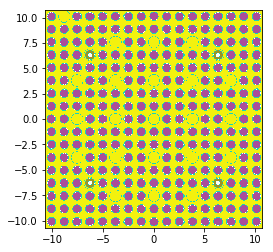

In [8]:
geom.root_universe.plot(color_by='material', width=(21.42, 21.42),
                        pixels=(400, 400), seed=2)

## Statepoint File

As cool as the summary file is, the statepoint file is usually more useful because it actually contains our simulation results. Here, we have statepoint file that was generated for the assembly model. We can read it is by creating a `StatePoint `object. Note that by default, data from the statepoint file is only read into memory when it is requested. This helps keep the memory use to a minimum even when a statepoint file may be huge.

In [9]:
# Load the statepoint file
sp = openmc.StatePoint('statepoint.50.h5')

The statepoint file has lots of interesting information inside: the $k_{\text{eff}}$ values by generation, the final $k_{\text{eff}}$, the final fission source, and of course the tallies. When `StatePoint` is instantiated, it will also look for a `summary.h5` file in the same directory and if present, it will automatically link it in so that geometry information is available as well.

Let's start off with a basic task -- plotting $k_\text{eff}$ by generation in our simulation.

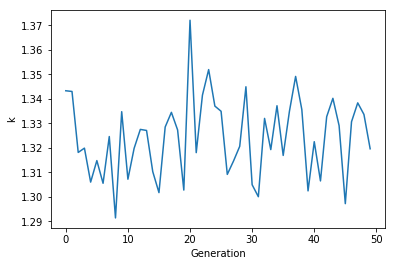

In [10]:
plt.plot(range(sp.n_batches), sp.k_generation)
plt.xlabel('Generation')
plt.ylabel('k')

Let's take a look at our tallies. Recall that in the lattices notebook, we set up a mesh tally and a distributed cell tally with IDs 1 and 2, respectively. To search for a particular tally, we use the `get_tally()` method which allows us to specify an ID, a name, a set of scores, a set of filters, etc., and it will return the first tally that matches our criterion.

In [11]:
tally = sp.get_tally(id=1)
tally

Tally
	ID             =	1
	Name           =	
	Filters        =	MeshFilter
	Nuclides       =	total U235 
	Scores         =	['total', 'fission']
	Estimator      =	tracklength

The statepoint file actually stores the sum and sum-of-squares for each tally bin from which the mean and variance can be calculated as described [here](http://openmc.readthedocs.io/en/latest/methods/tallies.html#variance). The raw sum and sum-of-squares can be accessed using the `sum` and `sum_sq` properties:

In [12]:
tally.sum

array([[[ 4.15354949,  0.07093615],
        [ 0.09368802,  0.06686386]],

       [[ 4.15510092,  0.07578745],
        [ 0.09941676,  0.07169413]],

       [[ 4.16946462,  0.07611028],
        [ 0.1000326 ,  0.07215103]],

       ..., 
       [[ 4.08502563,  0.07378807],
        [ 0.09712584,  0.06974463]],

       [[ 4.08218802,  0.07678031],
        [ 0.10096866,  0.0727539 ]],

       [[ 4.08377912,  0.07497003],
        [ 0.09814409,  0.07088415]]])

However, the mean and standard deviation of the mean are usually what you are more interested in. The Tally class also has properties ``mean`` and ``std_dev`` which automatically calculate these statistics on-the-fly.

In [13]:
print(tally.mean.shape)
(tally.mean, tally.std_dev)

(289, 2, 2)


(array([[[ 0.10383874,  0.0017734 ],
         [ 0.0023422 ,  0.0016716 ]],
 
        [[ 0.10387752,  0.00189469],
         [ 0.00248542,  0.00179235]],
 
        [[ 0.10423662,  0.00190276],
         [ 0.00250082,  0.00180378]],
 
        ..., 
        [[ 0.10212564,  0.0018447 ],
         [ 0.00242815,  0.00174362]],
 
        [[ 0.1020547 ,  0.00191951],
         [ 0.00252422,  0.00181885]],
 
        [[ 0.10209448,  0.00187425],
         [ 0.0024536 ,  0.0017721 ]]]),
 array([[[  1.09822899e-03,   4.16878437e-05],
         [  5.19401678e-05,   4.12362990e-05]],
 
        [[  9.58750871e-04,   3.76166764e-05],
         [  4.48124203e-05,   3.64959823e-05]],
 
        [[  9.28217497e-04,   3.86989079e-05],
         [  4.76001494e-05,   3.88290717e-05]],
 
        ..., 
        [[  9.48710687e-04,   4.73708278e-05],
         [  5.78639329e-05,   4.69371381e-05]],
 
        [[  9.52316348e-04,   4.36219762e-05],
         [  5.28834622e-05,   4.35279419e-05]],
 
        [[  1.05570432e-0

The tally data has three dimensions: one for filter combinations, one for nuclides, and one for scores. We see that there are 289 filter combinations (corresponding to the 17 x 17 mesh bins), two nuclides, and two scores. If we only want to look at a single score/nuclide, we can use the `get_slice()` method as follows.

In [14]:
total = tally.get_slice(scores=['total'], nuclides=['U235'])
fission = tally.get_slice(scores=['fission'], nuclides=['U235'])

To get the bins into a form that we can plot, we can simply change the shape of the array since it is a numpy array.

In [15]:
n = 17
total.std_dev.shape = (n, n)
total.mean.shape = (n, n)
fission.std_dev.shape = (n, n)
fission.mean.shape = (n, n)

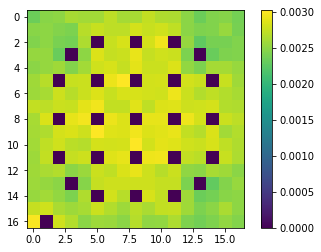

In [16]:
plt.imshow(total.mean)
plt.colorbar()

There are two problems here. First, our range of colors includes the guide tube values where we know there is no U235. To prevent these from polluting our plot, let's set those positions to NaN. Secondly, the plot is upside down (a guide tube was added near a corner to demonstrate this)! We can flip it using `numpy.flipud`. Alternatively, we could have used `total.mean[::-1, :]`. Let's also choose a diverging colormap to make it prettier.

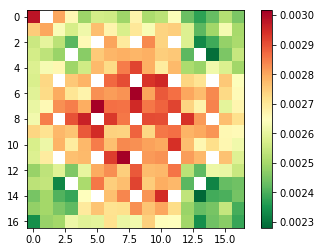

In [17]:
# Get rid of zero values
masked_total = total.mean.copy()
masked_total[masked_total == 0.0] = np.nan

# Flip the plot up-down
masked_total = np.flipud(masked_total)
plt.imshow(masked_total, cmap='RdYlGn_r')
plt.colorbar()

Now let's say we want to look at the distribution of relative errors of our tally bins for flux. First we create a new variable called ``relative_error`` and set it to the ratio of the standard deviation and the mean, being careful not to divide by zero in case some bins were never scored to.

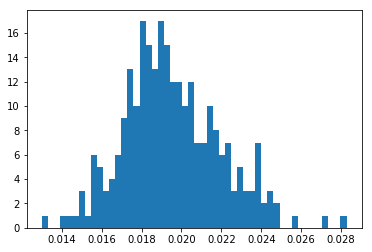

In [18]:
# Determine relative error
relative_error = np.zeros_like(total.std_dev)
nonzero = total.mean > 0
relative_error[nonzero] = total.std_dev[nonzero] / total.mean[nonzero]

# distribution of relative errors
ret = plt.hist(relative_error[nonzero], bins=50)

### Pandas Dataframes

So far, we've been dealing with raw tally data, and it's not always so obvious what the numbers that we're looking at mean. To get a "big picture" view of the tally results much in the same manner as the `tallies.out` does, there is a `get_pandas_dataframe()` method that leveras the [Pandas](http://pandas.pydata.org/) package. A `DataFrame` is essentially a table. When we ask a tally for its `DataFrame`, this shows us what each tally bin corresponds to.

In [19]:
df = tally.get_pandas_dataframe()
df

mesh 10002        nuclide    score     mean std. dev.
              x   y  z                                    
0             1   1  1   total    total 1.04e-01  1.10e-03
1             1   1  1   total  fission 1.77e-03  4.17e-05
2             1   1  1    U235    total 2.34e-03  5.19e-05
3             1   1  1    U235  fission 1.67e-03  4.12e-05
4             1   2  1   total    total 1.04e-01  9.59e-04
5             1   2  1   total  fission 1.89e-03  3.76e-05
6             1   2  1    U235    total 2.49e-03  4.48e-05
7             1   2  1    U235  fission 1.79e-03  3.65e-05
8             1   3  1   total    total 1.04e-01  9.28e-04
9             1   3  1   total  fission 1.90e-03  3.87e-05
10            1   3  1    U235    total 2.50e-03  4.76e-05
11            1   3  1    U235  fission 1.80e-03  3.88e-05
12            1   4  1   total    total 1.06e-01  8.74e-04
13            1   4  1   total  fission 2.00e-03  4.02e-05
14            1   4  1    U235    total 2.62e-03  4.87e-05
15            1   4  1    U235  fission 1.90e-03  4.01e-05
16            1   5  1   total    total 1.06e-01  8.56e-04
17            1   5  1   total  fission 1.97e-03  4.74e-05
18            1   5  1    U235    total 2.59e-03  5.76e-05
19            1   5  1    U235  fission 1.87e-03  4.78e-05
20            1   6  1   total    total 1.07e-01  9.79e-04
21            1   6  1   total  fission 1.98e-03  4.15e-05
22            1   6  1    U235    total 2.60e-03  5.18e-05
23            1   6  1    U235  fission 1.88e-03  4.16e-05
24            1   7  1   total    total 1.07e-01  9.92e-04
25            1   7  1   total  fission 2.08e-03  4.29e-05
26            1   7  1    U235    total 2.71e-03  5.40e-05
27            1   7  1    U235  fission 1.98e-03  4.33e-05
28            1   8  1   total    total 1.06e-01  8.82e-04
29            1   8  1   total  fission 2.00e-03  3.70e-05
...         ...  .. ..     ...      ...      ...       ...
1126         17  10  1    U235    total 2.51e-03  5.60e-05
1127         17  10  1    U235  fission 1.82e-03  4.53e-05
1128         17  11  1   total    total 1.05e-01  1.01e-03
1129         17  11  1   total  fission 1.93e-03  4.44e-05
1130         17  11  1    U235    total 2.53e-03  5.53e-05
1131         17  11  1    U235  fission 1.83e-03  4.44e-05
1132         17  12  1   total    total 1.05e-01  8.84e-04
1133         17  12  1   total  fission 2.02e-03  4.45e-05
1134         17  12  1    U235    total 2.64e-03  5.44e-05
1135         17  12  1    U235  fission 1.92e-03  4.45e-05
1136         17  13  1   total    total 1.02e-01  8.50e-04
1137         17  13  1   total  fission 1.85e-03  3.69e-05
1138         17  13  1    U235    total 2.43e-03  4.48e-05
1139         17  13  1    U235  fission 1.75e-03  3.71e-05
1140         17  14  1   total    total 1.01e-01  9.28e-04
1141         17  14  1   total  fission 1.80e-03  4.82e-05
1142         17  14  1    U235    total 2.38e-03  5.84e-05
1143         17  14  1    U235  fission 1.70e-03  4.78e-05
1144         17  15  1   total    total 1.02e-01  9.49e-04
1145         17  15  1   total  fission 1.84e-03  4.74e-05
1146         17  15  1    U235    total 2.43e-03  5.79e-05
1147         17  15  1    U235  fission 1.74e-03  4.69e-05
1148         17  16  1   total    total 1.02e-01  9.52e-04
1149         17  16  1   total  fission 1.92e-03  4.36e-05
1150         17  16  1    U235    total 2.52e-03  5.29e-05
1151         17  16  1    U235  fission 1.82e-03  4.35e-05
1152         17  17  1   total    total 1.02e-01  1.06e-03
1153         17  17  1   total  fission 1.87e-03  5.10e-05
1154         17  17  1    U235    total 2.45e-03  6.07e-05
1155         17  17  1    U235  fission 1.77e-03  5.05e-05

[1156 rows x 7 columns]

Fortunately, this also works on tally slices. Below we use the `get_pandas_dataframe()` method on our tally slice, but we could have also used optional arguments to `get_pandas_dataframe()` on the original tally to achieve the same purpose.

In [20]:
total.get_pandas_dataframe()

mesh 10002        nuclide  score     mean std. dev.
             x   y  z                                  
0            1   1  1    U235  total 2.34e-03  5.19e-05
1            1   2  1    U235  total 2.49e-03  4.48e-05
2            1   3  1    U235  total 2.50e-03  4.76e-05
3            1   4  1    U235  total 2.62e-03  4.87e-05
4            1   5  1    U235  total 2.59e-03  5.76e-05
5            1   6  1    U235  total 2.60e-03  5.18e-05
6            1   7  1    U235  total 2.71e-03  5.40e-05
7            1   8  1    U235  total 2.61e-03  4.46e-05
8            1   9  1    U235  total 2.62e-03  6.40e-05
9            1  10  1    U235  total 2.74e-03  5.48e-05
10           1  11  1    U235  total 2.65e-03  6.02e-05
11           1  12  1    U235  total 2.65e-03  6.31e-05
12           1  13  1    U235  total 2.50e-03  4.56e-05
13           1  14  1    U235  total 2.34e-03  5.22e-05
14           1  15  1    U235  total 2.44e-03  5.80e-05
15           1  16  1    U235  total 2.47e-03  4.84e-05
16           1  17  1    U235  total 2.38e-03  5.60e-05
17           2   1  1    U235  total 2.48e-03  4.64e-05
18           2   2  1    U235  total 2.50e-03  5.95e-05
19           2   3  1    U235  total 2.45e-03  3.85e-05
20           2   4  1    U235  total 2.42e-03  4.75e-05
21           2   5  1    U235  total 2.70e-03  5.00e-05
22           2   6  1    U235  total 2.76e-03  6.31e-05
23           2   7  1    U235  total 2.71e-03  5.84e-05
24           2   8  1    U235  total 2.72e-03  4.87e-05
25           2   9  1    U235  total 2.83e-03  5.44e-05
26           2  10  1    U235  total 2.76e-03  5.09e-05
27           2  11  1    U235  total 2.80e-03  5.05e-05
28           2  12  1    U235  total 2.72e-03  4.56e-05
29           2  13  1    U235  total 2.49e-03  5.08e-05
..         ...  .. ..     ...    ...      ...       ...
259         16   5  1    U235  total 2.62e-03  4.95e-05
260         16   6  1    U235  total 2.77e-03  5.99e-05
261         16   7  1    U235  total 2.67e-03  5.65e-05
262         16   8  1    U235  total 2.57e-03  4.54e-05
263         16   9  1    U235  total 2.70e-03  4.75e-05
264         16  10  1    U235  total 2.64e-03  5.36e-05
265         16  11  1    U235  total 2.74e-03  4.75e-05
266         16  12  1    U235  total 2.75e-03  6.05e-05
267         16  13  1    U235  total 2.58e-03  5.23e-05
268         16  14  1    U235  total 2.42e-03  5.15e-05
269         16  15  1    U235  total 2.50e-03  5.58e-05
270         16  16  1    U235  total 2.63e-03  5.59e-05
271         16  17  1    U235  total 2.51e-03  4.82e-05
272         17   1  1    U235  total 2.98e-03  8.43e-05
273         17   2  1    U235  total 0.00e+00  0.00e+00
274         17   3  1    U235  total 2.80e-03  6.45e-05
275         17   4  1    U235  total 2.66e-03  6.20e-05
276         17   5  1    U235  total 2.49e-03  5.34e-05
277         17   6  1    U235  total 2.57e-03  5.60e-05
278         17   7  1    U235  total 2.56e-03  5.54e-05
279         17   8  1    U235  total 2.49e-03  4.84e-05
280         17   9  1    U235  total 2.68e-03  6.13e-05
281         17  10  1    U235  total 2.51e-03  5.60e-05
282         17  11  1    U235  total 2.53e-03  5.53e-05
283         17  12  1    U235  total 2.64e-03  5.44e-05
284         17  13  1    U235  total 2.43e-03  4.48e-05
285         17  14  1    U235  total 2.38e-03  5.84e-05
286         17  15  1    U235  total 2.43e-03  5.79e-05
287         17  16  1    U235  total 2.52e-03  5.29e-05
288         17  17  1    U235  total 2.45e-03  6.07e-05

[289 rows x 7 columns]

DataFrames have built-in data analysis capabilities. For example, we can create a box plot of the mean values by score.

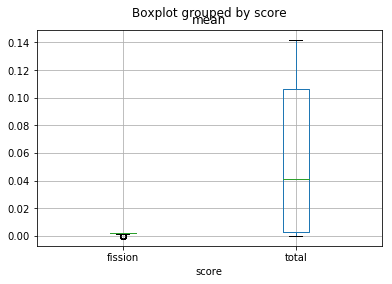

In [21]:
df.boxplot(column='mean', by='score')

We can also extract out data using `DataFrame` slicing. For example, before we saw that only three of our U235 total reaction rates had relative errors above 0.0025. To see which bins those are, we can do the following.

In [22]:
# Create new column for relative error
df['rel err'] = df['std. dev.'] / df['mean']

# Select U235 and total
u235_re = df[(df['nuclide'] == 'U235') & (df['score'] == 'total')]

# Show rows with relative error > 0.025
u235_re[u235_re['rel err'] > 0.025]

mesh 10002       nuclide  score      mean std. dev.   rel err
              x  y  z                                             
822          13  2  1    U235  total  0.002633  0.000068  0.025825
846          13  8  1    U235  total  0.002850  0.000077  0.027124
1090         17  1  1    U235  total  0.002982  0.000084  0.028270

One more nice feature is that if you have a distributed cell tally and the statepoint is linked to the summary file, the `DataFrame` will show the path information for each tally bin.

In [23]:
distrib_tally = sp.get_tally(id=2)
ddf = distrib_tally.get_pandas_dataframe()
ddf.head(10)

level 1        level 2       level 3        distribcell nuclide    score  \
     univ   cell     lat          univ   cell                                
       id     id      id  x  y      id     id                                
0   10014  10021   10011  0  0   10000  10000           0   total    total   
1   10014  10021   10011  0  0   10000  10000           0   total  fission   
2   10014  10021   10011  0  0   10000  10000           0    U235    total   
3   10014  10021   10011  0  0   10000  10000           0    U235  fission   
4   10014  10021   10011  0  1   10000  10000           1   total    total   
5   10014  10021   10011  0  1   10000  10000           1   total  fission   
6   10014  10021   10011  0  1   10000  10000           1    U235    total   
7   10014  10021   10011  0  1   10000  10000           1    U235  fission   
8   10014  10021   10011  0  2   10000  10000           2   total    total   
9   10014  10021   10011  0  2   10000  10000           2   total  fission   

       mean std. dev.  
                       
                       
0  0.021130  0.000238  
1  0.001773  0.000042  
2  0.002342  0.000052  
3  0.001672  0.000041  
4  0.021092  0.000194  
5  0.001884  0.000039  
6  0.002481  0.000046  
7  0.001785  0.000039  
8  0.021051  0.000188  
9  0.001859  0.000039

Let's select only those bins that correspond to lattice position (0, 16).

In [24]:
ddf[(ddf['level 2', 'lat', 'x'] == 0) &
    (ddf['level 2', 'lat', 'y'] == 16)]

level 1        level 2        level 3        distribcell nuclide    score  \
      univ   cell     lat           univ   cell                                
        id     id      id  x   y      id     id                                
64   10014  10021   10011  0  16   10000  10000          16   total    total   
65   10014  10021   10011  0  16   10000  10000          16   total  fission   
66   10014  10021   10011  0  16   10000  10000          16    U235    total   
67   10014  10021   10011  0  16   10000  10000          16    U235  fission   

        mean std. dev.  
                        
                        
64  0.021872  0.000255  
65  0.002302  0.000069  
66  0.002982  0.000084  
67  0.002201  0.000069

## Source Sites

Source sites can be accessed from the ``source`` property. As shown below, the source sites are represented as a numpy array with a structured datatype.

In [26]:
sp.source

array([ (1.0, [-8.663435307988035, -6.30842936492925, -22.30867427654424], [0.023550547577536163, -0.8860109298989289, 0.46306587415661876], 1535752.4040636136, 0),
       (1.0, [6.427729412910335, 10.435621866894245, -37.32161782999026], [-0.9731374735987592, -0.06448079959397794, 0.22101059694400504], 1950832.540821312, 0),
       (1.0, [6.427729412910335, 10.435621866894245, -37.32161782999026], [0.3860371716602964, -0.702511658346241, 0.5978734581699822], 192060.0149601462, 0),
       ...,
       (1.0, [3.7585364384900375, 9.912202860012211, -26.593980610629107], [-0.41035813814991595, -0.5117143934338976, 0.7548208913422527], 242319.39953524302, 0),
       (1.0, [-7.440756283630235, 7.487509302447341, -7.00129662221812], [-0.8817175217109556, 0.4587419045317211, 0.11013662848707408], 4687365.137738035, 0),
       (1.0, [7.297220500070954, 8.708951476336317, -0.8557137986325525], [-0.6487555728660874, -0.7609042980553066, 0.011868271826847104], 717760.5912048037, 0)], 
      dtype=

If we want, say, only the energies from the source sites, we can simply index the source array with the name of the field:

In [27]:
sp.source['E']

array([ 1535752.40406361,  1950832.54082131,   192060.01496015, ...,
         242319.39953524,  4687365.13773804,   717760.5912048 ])

Now, we can look at things like the energy distribution of source sites. Note that we don't directly use the ``matplotlib.pyplot.hist`` method since our binning is logarithmic.

[ 0.          0.          0.          0.          0.          0.00010017
  0.          0.          0.          0.          0.          0.
  0.00010017  0.          0.00010017  0.00020034  0.00050085  0.00050085
  0.00060102  0.00080136  0.00070119  0.00180307  0.00210358  0.00150255
  0.0027046   0.00460783  0.00661124  0.00811379  0.01061805  0.01362316
  0.01762997  0.02253832  0.02824802  0.03455875  0.04096965  0.04978463
  0.06481018  0.07402584  0.08133828  0.08534509  0.09245718  0.0903536
  0.08033657  0.0664129   0.04708004  0.03355705  0.02193729  0.00921567
  0.00410698]
1.0


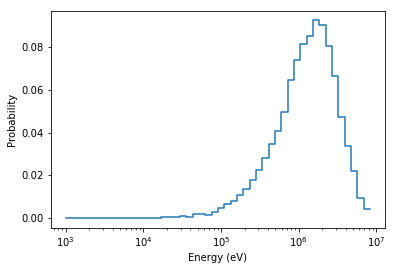

In [28]:
# Create log-spaced energy bins from 1 keV to 100 MeV
energy_bins = np.logspace(3,7)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['E'], energy_bins, density=True)
print(probability*np.diff(energy_bins))

# Make sure integrating the PDF gives us unity
print(sum(probability*np.diff(energy_bins)))

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), linestyle='steps')
plt.xlabel('Energy (eV)')
plt.ylabel('Probability')

Let's also look at the spatial distribution of the sites. To make the plot a little more interesting, we can also include the direction of the particle emitted from the source and color each source by the logarithm of its energy.

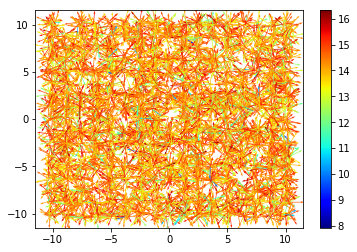

In [29]:
plt.quiver(sp.source['xyz'][:,0], sp.source['xyz'][:,1],
           sp.source['uvw'][:,0], sp.source['uvw'][:,1],
           np.log(sp.source['E']), cmap='jet', scale=20.0)
plt.colorbar()